# 01 Data ingestion

## a. Notebook setup

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Define data path
INPUT_PATH = '/content/drive/MyDrive/266_Final_Project/Input_Data/NumHG-main/Dataset/'
PROCESSED_PATH = '/content/drive/MyDrive/266_Final_Project/Processed_Data/'

In [3]:
!ls /content/drive/MyDrive/266_Final_Project/Input_Data/NumHG-main/

Dataset  examples  numhg_eval.py  README.md  requirements.txt


In [4]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==1

In [5]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datasets import Dataset,load_from_disk

In [6]:
# Set seed for data shuffling
np.random.seed(42)
pd_random_state = 24

## b. Intake of train/test data

In [7]:
# Loop through data directories to compile train/test data, and shuffle data
train_pd_all = pd.concat([pd.read_csv(f'{INPUT_PATH}/{dir}/train.csv') for dir in ['fold-1','fold-2','fold-3','fold-4','fold-5']]).sample(frac=1).reset_index(drop = True)
test_pd_all = pd.concat([pd.read_csv(f'{INPUT_PATH}/{dir}/test.csv') for dir in ['fold-1','fold-2','fold-3','fold-4','fold-5']]).sample(frac=1).reset_index(drop = True)

In [ ]:
# Check percentage of cloze_gt with "/" character
print(train_pd_all['cloze_gt'].str.contains('/').sum() / len(train_pd_all))
print(test_pd_all['cloze_gt'].str.contains('/').sum() / len(test_pd_all))

0.011368551127587272
0.010488376284015138


In [8]:
print(train_pd_all.shape)
print(test_pd_all.shape)

(97110, 6)
(27745, 6)


In [ ]:
# Sample datasets for improved runtime
train_pd = train_pd_all.sample(frac=0.1, random_state=pd_random_state).reset_index(drop = True)
test_pd = test_pd_all.sample(frac=0.1, random_state=pd_random_state).reset_index(drop = True)

# Sample reasoning-only texts from data
train_pd_reasoning_small = train_pd[train_pd['need_reasoning'] == 1].reset_index(drop = True)
train_pd_reasoning = train_pd_all[train_pd_all['need_reasoning'] == 1].sample(frac=0.33, random_state=pd_random_state).reset_index(drop = True)

## c. Exploratory Data Analysis

In [ ]:
print(train_pd.shape)
print(test_pd.shape)
print(train_pd_reasoning_small.shape)
print(train_pd_reasoning.shape)

(9711, 6)
(2774, 6)
(2965, 6)
(9711, 6)


In [ ]:
# Examine variable names
train_pd.columns

Index(['text', 'summary', 'cloze', 'cloze_gt', 'cloze_annotation',
       'need_reasoning'],
      dtype='object')

In [ ]:
# First few rows of data
train_pd.head(5)

,text,summary,cloze,cloze_gt,cloze_annotation,need_reasoning
0,"(Dec 28, 2011 12:03 AM) In what's believed to...",Mel Gibson Loses Half His $850M Fortune,Mel Gibson Loses Half His $____M Fortune,850,"Divide( 425 , .5 )",1
1,"(May 1, 2008 3:33 AM CDT) Suspected wife kill...",Peterson Offers $25K Reward for Wife's Return,Peterson Offers $____K Reward for Wife's Return,25,"Paraphrase( 25,000 , K )",1
2,"(Sep 25, 2016 1:28 PM CDT) Authorities say se...",Melee in Boston's Theater District Leaves 7 In...,Melee in Boston's Theater District Leaves ____...,7,Trans( seven ),1
3,"(Jan 28, 2008 9:08 AM) Jérôme Kerviel, the ro...","SocGen Trader Charged, Faces 7 Years","SocGen Trader Charged, Faces ____ Years",7,Copy( 7 ),0
4,"(Jun 30, 2015 3:33 AM CDT) Today is going to ...",Today Will Be the Longest Day Since 2012,Today Will Be the Longest Day Since ____,2012,Copy( 2012 ),0


In [ ]:
# Count of observations
train_pd.count(axis=0)

,0
text,9711
summary,9711
cloze,9711
cloze_gt,9711
cloze_annotation,9711
need_reasoning,9711


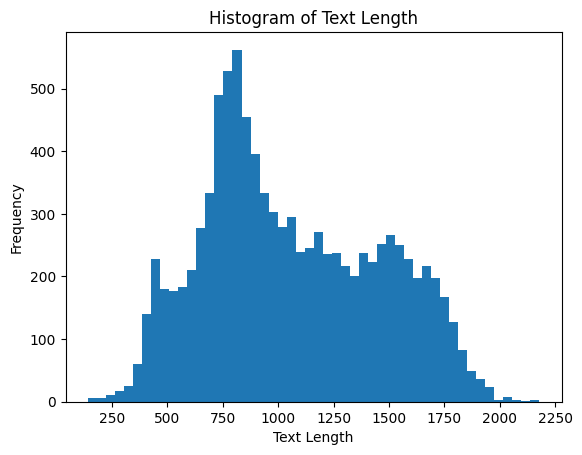

In [ ]:
# Text length distribution
train_pd['text_length'] = train_pd['text'].str.len()

plt.hist(train_pd['text_length'], bins=50)

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length')

plt.show()

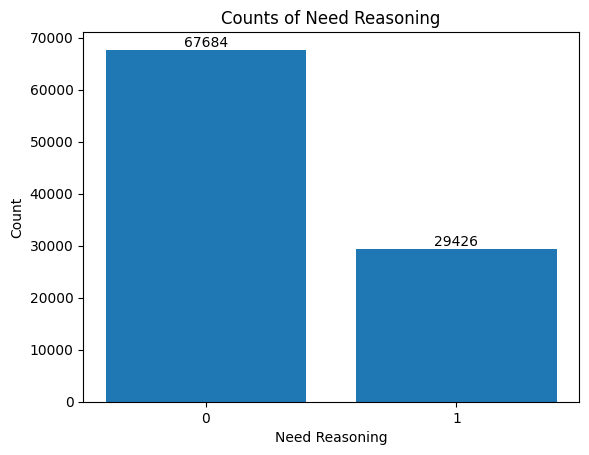

In [9]:
# Generate plot of counts of "need_reasoning" using train_pd. Show the counts in the graph

# Summary df of "need_reasoning" for plotting
need_reasoning_counts = train_pd_all['need_reasoning'].value_counts()

# Plot chart
plt.bar(need_reasoning_counts.index, need_reasoning_counts.values)
plt.xlabel('Need Reasoning')
plt.ylabel('Count')
plt.title('Counts of Need Reasoning')

# Add counts to the bars
for i, v in enumerate(need_reasoning_counts.values):
  plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Get current axes
ax = plt.gca()

# Set X-axis tick intervals (adjust range and step as needed)
ax.set_xticks(range(0, 2, 1))

# Show chart
plt.show()

In [ ]:
# Show "need_reasoning" counts by table
train_pd['need_reasoning'].value_counts()

,count
need_reasoning,
0,6746
1,2965


## d. Master dataset

In [ ]:
train_pd.head(5)

,text,summary,cloze,cloze_gt,cloze_annotation,need_reasoning,text_length
0,"(Dec 28, 2011 12:03 AM) In what's believed to...",Mel Gibson Loses Half His $850M Fortune,Mel Gibson Loses Half His $____M Fortune,850,"Divide( 425 , .5 )",1,1258
1,"(May 1, 2008 3:33 AM CDT) Suspected wife kill...",Peterson Offers $25K Reward for Wife's Return,Peterson Offers $____K Reward for Wife's Return,25,"Paraphrase( 25,000 , K )",1,614
2,"(Sep 25, 2016 1:28 PM CDT) Authorities say se...",Melee in Boston's Theater District Leaves 7 In...,Melee in Boston's Theater District Leaves ____...,7,Trans( seven ),1,1201
3,"(Jan 28, 2008 9:08 AM) Jérôme Kerviel, the ro...","SocGen Trader Charged, Faces 7 Years","SocGen Trader Charged, Faces ____ Years",7,Copy( 7 ),0,849
4,"(Jun 30, 2015 3:33 AM CDT) Today is going to ...",Today Will Be the Longest Day Since 2012,Today Will Be the Longest Day Since ____,2012,Copy( 2012 ),0,1393


### d.i. ModernBERT data processing

In [ ]:
# Remove timestamps
train_pd['text_bert'] = train_pd['text'].str.replace(r'^\(.+\) ', '', regex=True)
test_pd['text_bert'] = test_pd['text'].str.replace(r'^\(.+\) ', '', regex=True)
train_pd_reasoning_small['text_bert'] = train_pd_reasoning_small['text'].str.replace(r'^\(.+\) ', '', regex=True)
train_pd_reasoning['text_bert'] = train_pd_reasoning['text'].str.replace(r'^\(.+\) ', '', regex=True)

# Format ModernBERT mask, ensuring [MASK] is input with no extra characters attached
train_pd['cloze_bert'] = train_pd['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
test_pd['cloze_bert'] = test_pd['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
train_pd_reasoning_small['cloze_bert'] = train_pd_reasoning_small['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
train_pd_reasoning['cloze_bert'] = train_pd_reasoning['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)

# Remove extra whitespaces created from creating mask
train_pd['cloze_bert'] = train_pd['cloze_bert'].str.replace(r'\s+', ' ', regex=True)
test_pd['cloze_bert'] = test_pd['cloze_bert'].str.replace(r'\s+', ' ', regex=True)
train_pd_reasoning_small['cloze_bert'] = train_pd_reasoning_small['cloze_bert'].str.replace(r'\s+', ' ', regex=True)
train_pd_reasoning['cloze_bert'] = train_pd_reasoning['cloze_bert'].str.replace(r'\s+', ' ', regex=True)

# Concatenate masked summary and input text into one feature
train_pd['text_bert'] = train_pd['cloze_bert'] + '. ' + train_pd['text_bert']
test_pd['text_bert'] = test_pd['cloze_bert'] + '. ' + test_pd['text_bert']
train_pd_reasoning_small['text_bert'] = train_pd_reasoning_small['cloze_bert'] + '. ' + train_pd_reasoning_small['text_bert']
train_pd_reasoning['text_bert'] = train_pd_reasoning['cloze_bert'] + '. ' + train_pd_reasoning['text_bert']

train_pd.head(5)

,text,summary,cloze,cloze_gt,cloze_annotation,need_reasoning,text_length,text_bert,cloze_bert
0,"(Dec 28, 2011 12:03 AM) In what's believed to...",Mel Gibson Loses Half His $850M Fortune,Mel Gibson Loses Half His $____M Fortune,850,"Divide( 425 , .5 )",1,1258,Mel Gibson Loses Half His $ [MASK] M Fortune. ...,Mel Gibson Loses Half His $ [MASK] M Fortune
1,"(May 1, 2008 3:33 AM CDT) Suspected wife kill...",Peterson Offers $25K Reward for Wife's Return,Peterson Offers $____K Reward for Wife's Return,25,"Paraphrase( 25,000 , K )",1,614,Peterson Offers $ [MASK] K Reward for Wife's R...,Peterson Offers $ [MASK] K Reward for Wife's R...
2,"(Sep 25, 2016 1:28 PM CDT) Authorities say se...",Melee in Boston's Theater District Leaves 7 In...,Melee in Boston's Theater District Leaves ____...,7,Trans( seven ),1,1201,Melee in Boston's Theater District Leaves [MAS...,Melee in Boston's Theater District Leaves [MAS...
3,"(Jan 28, 2008 9:08 AM) Jérôme Kerviel, the ro...","SocGen Trader Charged, Faces 7 Years","SocGen Trader Charged, Faces ____ Years",7,Copy( 7 ),0,849,"SocGen Trader Charged, Faces [MASK] Years. Jér...","SocGen Trader Charged, Faces [MASK] Years"
4,"(Jun 30, 2015 3:33 AM CDT) Today is going to ...",Today Will Be the Longest Day Since 2012,Today Will Be the Longest Day Since ____,2012,Copy( 2012 ),0,1393,Today Will Be the Longest Day Since [MASK] . T...,Today Will Be the Longest Day Since [MASK]


### d.ii. T5/Gemma3 data processing

In [ ]:
# Remove timestamps
train_pd['text_triplet'] = train_pd['text'].str.replace(r'^\(.+\) ', '', regex=True)
test_pd['text_triplet'] = test_pd['text'].str.replace(r'^\(.+\) ', '', regex=True)
train_pd_reasoning_small['text_triplet'] = train_pd_reasoning_small['text'].str.replace(r'^\(.+\) ', '', regex=True)
train_pd_reasoning['text_triplet'] = train_pd_reasoning['text'].str.replace(r'^\(.+\) ', '', regex=True)

# Format Gemma3 mask, ensuring [MASK] is input with no extra characters attached
train_pd['cloze_triplet'] = train_pd['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
test_pd['cloze_triplet'] = test_pd['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
train_pd_reasoning_small['cloze_triplet'] = train_pd_reasoning_small['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)
train_pd_reasoning['cloze_triplet'] = train_pd_reasoning['cloze'].str.replace(r'_+', ' [MASK] ', regex=True)

# Remove extra whitespaces created from creating mask
train_pd['cloze_triplet'] = train_pd['cloze_triplet'].str.replace(r'\s+', ' ', regex=True)
test_pd['cloze_triplet'] = test_pd['cloze_triplet'].str.replace(r'\s+', ' ', regex=True)
train_pd_reasoning_small['cloze_triplet'] = train_pd_reasoning_small['cloze_triplet'].str.replace(r'\s+', ' ', regex=True)
train_pd_reasoning['cloze_triplet'] = train_pd_reasoning['cloze_triplet'].str.replace(r'\s+', ' ', regex=True)

train_pd_reasoning.head(5)

,text,summary,cloze,cloze_gt,cloze_annotation,need_reasoning,text_bert,cloze_bert,text_triplet,cloze_triplet
0,"(Jul 26, 2019 9:19 AM CDT) Three University o...",Ole Miss Frat Suspends 3 Over Photo at Emmett ...,Ole Miss Frat Suspends ____ Over Photo at Emme...,3,Trans( Three ),1,Ole Miss Frat Suspends [MASK] Over Photo at Em...,Ole Miss Frat Suspends [MASK] Over Photo at Em...,Three University of Mississippi students have ...,Ole Miss Frat Suspends [MASK] Over Photo at Em...
1,"(Oct 11, 2012 9:50 AM CDT) A teenager has won...",Teen Scores $60K for Google Hack,Teen Scores $____K for Google Hack,60,"Paraphrase( 60,000 , K )",1,Teen Scores $ [MASK] K for Google Hack. A teen...,Teen Scores $ [MASK] K for Google Hack,"A teenager has won $60,000 for a critical ha...",Teen Scores $ [MASK] K for Google Hack
2,"(Sep 3, 2009 3:20 PM CDT) Stocks jumped today...",Dow Climbs 64 as Investors Await Jobs Report,Dow Climbs ____ as Investors Await Jobs Report,64,"Round( 63.94 , 0 )",1,Dow Climbs [MASK] as Investors Await Jobs Repo...,Dow Climbs [MASK] as Investors Await Jobs Report,Stocks jumped today on the strength of blue-ch...,Dow Climbs [MASK] as Investors Await Jobs Report
3,"(Sep 15, 2013 3:21 PM CDT) Iowa Senator Tom H...","If Biden Runs in '16, Iowa's Got His Back","If Biden Runs in '____, Iowa's Got His Back",16,"Subtract( 2016 , 2000 )",1,"If Biden Runs in ' [MASK] , Iowa's Got His Bac...","If Biden Runs in ' [MASK] , Iowa's Got His Back",Iowa Senator Tom Harkin is hosting his 36th s...,"If Biden Runs in ' [MASK] , Iowa's Got His Back"
4,"(May 8, 2011 12:57 PM CDT) Members of al-Qaed...",18 Dead After al-Qaeda Jail Uprising in Iraq,____ Dead After al-Qaeda Jail Uprising in Iraq,18,"Add( 11 , Trans( seven ) )",1,[MASK] Dead After al-Qaeda Jail Uprising in I...,[MASK] Dead After al-Qaeda Jail Uprising in Iraq,Members of al-Qaeda staged a deadly attempt to...,[MASK] Dead After al-Qaeda Jail Uprising in Iraq


## e. Formatting data for ModernBERT intake

In [ ]:
# Keep only the text and label features
train_pd_bert = train_pd[['text_bert', 'cloze_gt']]
train_pd_bert_reasoning_small = train_pd_reasoning_small[['text_bert', 'cloze_gt']]
train_pd_bert_reasoning = train_pd_reasoning[['text_bert', 'cloze_gt']]
test_pd_bert = test_pd[['text_bert', 'cloze_gt', 'need_reasoning']]

# Rename label variable
train_pd_bert = train_pd_bert.rename(columns={'text_bert': 'text', 'cloze_gt': 'labels'})
train_pd_bert_reasoning_small = train_pd_bert_reasoning_small.rename(columns={'text_bert': 'text', 'cloze_gt': 'labels'})
train_pd_bert_reasoning = train_pd_bert_reasoning.rename(columns={'text_bert': 'text', 'cloze_gt': 'labels'})
test_pd_bert = test_pd_bert.rename(columns={'text_bert': 'text', 'cloze_gt': 'labels'})

# First few rows of data
train_pd_bert.head(5)

,text,labels
0,Mel Gibson Loses Half His $ [MASK] M Fortune. ...,850
1,Peterson Offers $ [MASK] K Reward for Wife's R...,25
2,Melee in Boston's Theater District Leaves [MAS...,7
3,"SocGen Trader Charged, Faces [MASK] Years. Jér...",7
4,Today Will Be the Longest Day Since [MASK] . T...,2012


## f. Formatting data for T5/Gemma3 intake

In [ ]:
# Keep only the text and label features
train_pd_triplet = train_pd[['text_triplet', 'cloze_triplet', 'cloze_gt']]
test_pd_triplet = test_pd[['text_triplet', 'cloze_triplet', 'cloze_gt']]
train_pd_triplet_reasoning_small = train_pd_reasoning_small[['text_triplet', 'cloze_triplet', 'cloze_gt']]
train_pd_triplet_reasoning = train_pd_reasoning[['text_triplet', 'cloze_triplet', 'cloze_gt']]

# Rename label variable
train_pd_triplet = train_pd_triplet.rename(columns={'text_triplet': 'context', 'cloze_triplet': 'question', 'cloze_gt': 'labels'})
test_pd_triplet = test_pd_triplet.rename(columns={'text_triplet': 'context', 'cloze_triplet': 'question', 'cloze_gt': 'labels'})
train_pd_triplet_reasoning_small = train_pd_triplet_reasoning_small.rename(columns={'text_triplet': 'context', 'cloze_triplet': 'question', 'cloze_gt': 'labels'})
train_pd_triplet_reasoning = train_pd_triplet_reasoning.rename(columns={'text_triplet': 'context', 'cloze_triplet': 'question', 'cloze_gt': 'labels'})

# First few rows of data
train_pd_triplet_reasoning.head(5)

,context,question,labels
0,Three University of Mississippi students have ...,Ole Miss Frat Suspends [MASK] Over Photo at Em...,3
1,"A teenager has won $60,000 for a critical ha...",Teen Scores $ [MASK] K for Google Hack,60
2,Stocks jumped today on the strength of blue-ch...,Dow Climbs [MASK] as Investors Await Jobs Report,64
3,Iowa Senator Tom Harkin is hosting his 36th s...,"If Biden Runs in ' [MASK] , Iowa's Got His Back",16
4,Members of al-Qaeda staged a deadly attempt to...,[MASK] Dead After al-Qaeda Jail Uprising in Iraq,18


## g. Convert to Huggingface dataset and save

### g.i. ModernBERT

In [ ]:
# Converting PD to HF
train_hf_bert = Dataset.from_pandas(train_pd_bert)
train_hf_bert_reasoning_small = Dataset.from_pandas(train_pd_bert_reasoning_small)
train_hf_bert_reasoning = Dataset.from_pandas(train_pd_bert_reasoning)
test_hf_bert = Dataset.from_pandas(test_pd_bert)

In [ ]:
train_hf_bert

Dataset({
    features: ['text', 'labels'],
    num_rows: 9711
})

In [ ]:
test_hf_bert

Dataset({
    features: ['text', 'labels', 'need_reasoning'],
    num_rows: 2774
})

In [ ]:
for i in range(2):
  print(train_hf_bert['text'][i])
  print(train_hf_bert['labels'][i])
  print()

Mel Gibson Loses Half His $ [MASK] M Fortune. In what's believed to be the largest Hollywood divorce settlement in history, Mel Gibson is having to cough up $425 million—half of his estimated fortune—to ex-wife Robyn Denise Moore. The two, married 31 years and parents to seven children, didn't have a prenuptial agreement, so Moore is entitled to half his wealth under California law. Moore, a former dental nurse, is also entitled to half of any future residuals from films Gibson, 55, worked on while the two were married, reports People. The settlement was finalized by a judge last week. Gibson earned $600 million alone from his The Passion of the Christ. He also made money from real estate, including a Fiji island he bought for $15 million. Moore, 55, filed for divorce from Gibson in 2009 after he began a highly publicized, crazed affair with Oksana Grigorieva. Moore and Gibson met in the late 1970s when they were both tenants in a house in Australia. Of all their children, only a 12-ye

In [ ]:
# Save HF data to Drive
train_hf_bert.save_to_disk(f'{PROCESSED_PATH}/train_bert.hf')
test_hf_bert.save_to_disk(f'{PROCESSED_PATH}/test_bert.hf')

# Save HF reasoning data to Drive
train_hf_bert_reasoning_small.save_to_disk(f'{PROCESSED_PATH}/train_bert_reasoning_small.hf')
train_hf_bert_reasoning.save_to_disk(f'{PROCESSED_PATH}/train_bert_reasoning.hf')

Saving the dataset (0/1 shards):   0%|          | 0/9711 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2774 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2965 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9711 [00:00<?, ? examples/s]

### g.ii. T5/Gemma3

In [ ]:
# Converting PD to HF
train_hf_triplet = Dataset.from_pandas(train_pd_triplet)
test_hf_triplet = Dataset.from_pandas(test_pd_triplet)

train_hf_triplet_reasoning_small = Dataset.from_pandas(train_pd_triplet_reasoning_small)
train_hf_triplet_reasoning = Dataset.from_pandas(train_pd_triplet_reasoning)

In [ ]:
# Save HF data to Drive
train_hf_triplet.save_to_disk(f'{PROCESSED_PATH}/train_triplet.hf')
test_hf_triplet.save_to_disk(f'{PROCESSED_PATH}/test_triplet.hf')

# Save HF reasoning data to Drive
train_hf_triplet_reasoning_small.save_to_disk(f'{PROCESSED_PATH}/train_triplet_reasoning_small.hf')
train_hf_triplet_reasoning.save_to_disk(f'{PROCESSED_PATH}/train_triplet_reasoning.hf')

Saving the dataset (0/1 shards):   0%|          | 0/9711 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2774 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2965 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9711 [00:00<?, ? examples/s]

In [ ]:
# Save HF data to Drive
train_hf_triplet.to_parquet(PROCESSED_PATH + 'train_triplet.parquet')
test_hf_triplet.to_parquet(PROCESSED_PATH + 'test_triplet.parquet')

# Save HF reasoning data to Drive as Parquet
train_hf_triplet_reasoning_small.to_parquet(PROCESSED_PATH + 'train_triplet_reasoning_small.parquet')
train_hf_triplet_reasoning.to_parquet(PROCESSED_PATH + 'train_triplet_reasoning.parquet')

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

10283946

## h. Inspect abnormal labels

In [ ]:
import pyarrow.parquet as pq

test_hf_triplet = load_from_disk(f'{PROCESSED_PATH}/test_triplet.hf')

In [ ]:
# prompt: from test_hf_triplet, give context , question and label where label contains comma or fullstop

from datasets import load_from_disk

PROCESSED_PATH = '/content/drive/MyDrive/266_Final_Project/Processed_Data/'
test_hf_triplet = load_from_disk(f'{PROCESSED_PATH}/test_triplet.hf')

for i in range(len(test_hf_triplet)):
  if ',' in test_hf_triplet['labels'][i] or '.' in test_hf_triplet['labels'][i]:
    print("Context:", test_hf_triplet['context'][i])
    print("Question:", test_hf_triplet['question'][i])
    print("Label:", test_hf_triplet['labels'][i])
    print()

Context: New York Mayor Michael Bloomberg has already spent $18.7 million in his bid for a third term, outpacing his own 2005 campaign by 55%, the New York Daily News reports. The billionaire's three main competitors have spent a combined total of about $2.5 million, with controller William Thompson leading the way at $1.4 million. The election is 6 months away. Bloomberg spokesman Howard Wolfson denied that the money was buying votes.  Absolutely not,  he said.  We're engaging in a dialogue with voters. That's what any campaign does.  In 2005, Wolfson—then a vocal Bloomberg critic—said the mayor’s money was distorting  the terms of the debate.
Question: Bloomberg Drops $ [MASK] M on Campaign
Label: 18.7

Context: So, you've heard that Americans typically wolf down more than 4,500 calories on Thanksgiving Day? That's what the Calorie Control Council says, but Tara Parker-Pope at the New York Times was skeptical. So she cooked up a highly indulgent Thanksgiving meal, including 6 ounces 

In [ ]:
for i in range(len(test_hf_triplet)):
    if not ( ',' in test_hf_triplet['labels'][i] or '.' in test_hf_triplet['labels'][i] ):
      if not test_hf_triplet['labels'][i].isdigit():
          print("Location :", i)
          print("Context:", test_hf_triplet['context'][i])
          print("Question:", test_hf_triplet['question'][i])
          print("Label:", test_hf_triplet['labels'][i])

Location : 149
Context: had been alerted by federal authorities that terrorists usually  conduct surveillance before attacking a target.
Question: We Saw Terrorists Spying at Airport Way Before [MASK] : Witnesses
Label: 9/11
Location : 181
Context: A potent symbol of survival on 9/11—a 37-step staircase used by thousands to escape the Twin Towers—was temporarily moved yesterday as part of a compromise plan that will incorporate the structure into the World Trade Center memorial. The stairs were hoisted on a flatbed and shifted to another part of the site while rebuilding continues, reports WNBC-Channel 4 in New York. The stairs are the last remnant of the towers above ground. One survivor vividly recalled using them after the south tower collapsed and he tunneled through debris.  Time seemed to move very fast,  he said.  It took me about 20 minutes to tunnel out, just digging. I had no fingernails left when I got to the top.  The stairs had been threatened with demolition to make way f

In [ ]:
for i in range(len(train_hf_triplet)):
    if not ( ',' in train_hf_triplet['labels'][i] or '.' in train_hf_triplet['labels'][i] ):
      if not train_hf_triplet['labels'][i].isdigit():
          print("Location :", i)
          print("Context:", train_hf_triplet['context'][i])
          print("Question:", train_hf_triplet['question'][i])
          print("Label:", train_hf_triplet['labels'][i])

Location : 19
Context: A US airstrike in Syria has killed a key figure in a dangerous al-Qaeda offshoot, the Pentagon said today. Muhsin al-Fadhli was killed in a July 8 air attack while traveling in a vehicle near Sarmada, Syria, said Pentagon spokesman Capt. Jeff Davis. He did not say whether al-Fadhli was killed by a drone or a piloted aircraft. Al-Fadhli was a leader of the Khorasan Group, a cadre of al-Qaeda operatives who were sent from Pakistan to Syria to plot attacks on the West. Davis noted that he was  among the few trusted al-Qaeda leaders  who received advanced notice of the 9/11 attacks. Officials say the Khorasan Group is embedded in the al Nusra front, Syria's al-Qaeda affiliate. Previously based in Iran, al-Fadhli was the subject of a $7 million reward by the State Department for information leading to his capture or death. He had been falsely reported as having been killed last fall. He also was reportedly involved in October 2002 attacks against US Marines on Faylaka